# <span style="color:orange; font-weight:bold">DEEP LEARNING MINI PROJECT CS60010<br>SPRING SEMESTER 2023 - 2024 IIT KHARAGPUR</span>

## <span style="color:violet; font-weight:bold">Task: Build encoder decoder models for Automatic Image Captioning</span>
## <span style="color:violet; font-weight:bold">Part A: CNN-based encoder for the image and RNN-based decoder model</span>
## Group 26 Team members:
### - **Rajanyo Paul - 23CS60R82**
### - **Dipan Mandal - 23CS60R04**
### - **Avik Pramanick - 23CS60R78**
### - **Soham Banerjee - 23CS60R42**


### First installing some modules & importing dependencies

In [1]:
!pip install nltk
!pip install rouge
! pip install torchsummary
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-nquzd0u4
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-nquzd0u4
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=607e08673632f7212956405175aade4649c8b4b26ce9716c6ccb023be168048c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jte0kqzt/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [23]:
import os
import io
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import warnings
import torch
import zipfile
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, io
import torchvision.models as models
import torch.nn.functional as func
import torchsummary

from PIL import Image
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.transforms import Lambda, Resize, Normalize, Compose, ToTensor
from ipywidgets import Dropdown, Output, VBox
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from rouge import Rouge

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Preprocessing
### This is the first part of the assignment that includes data parsing and formatting. For that we have implemented...
**class Vocabulary** : Creates the vocabulary for the model that is to be trained. Uses 'nltk word tokenizer' to tokenize the captions into words and assigns a unique index to it for reference.

**class CustomDataset** : Loads the images & their respective captions using 'load_csv()' and then builds the vocabulary, transforms the image and numericalized caption to tensor format and returns them.

**load_csv()** : Given the parent folder and the sub folder name it loads the respective csv file.

**transform_image()** : Resizes, normalizes and transforms the given image to tensor format.

**collate_fn()** : For a batch it finds the largest caption and makes sure that every other caption in that is of same length for better learning by the model.

**get_loader()** : Makes a dataloader object

In [3]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.idx2word = {0 : '<PAD>', 1 : '<START>', 2 : '<END>', 3 : '<UNK>'}
        self.word2idx = {value : key for key, value in self.idx2word.items()}
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.idx2word)
    
    def tokenizer_eng(self, text):
        return word_tokenize(text.lower())
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                
                
                if frequencies[word] == self.freq_threshold:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1
      
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.word2idx[token] if token in self.word2idx else self.word2idx['<UNK>'] for token in tokenized_text]
        

In [4]:
def load_csv(data_folder, data_type ='train'):
    csv_file_path = os.path.join(data_folder, f'{data_type}.csv')
    return pd.read_csv(csv_file_path)

In [5]:
def transform_image():
    return transforms.Compose([transforms.Resize((224, 224), antialias = True),
                               transforms.ToTensor(),
                               transforms.RandomHorizontalFlip(),
                               transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

In [6]:
def collate_fn(batch, pad_idx):
    images = [item[0].unsqueeze(0) for item in batch]
    images = torch.cat(images, dim = 0)
    
    captions = [item[1] for item in batch]
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first = True, padding_value = pad_idx)
    return images, captions

We designed CustomDataset class to streamline preparing images and captions for an image captioning model. It takes a root directory and dataset type (like 'train' or 'test'), optionally applies transformations to images for consistency, and either uses a provided vocabulary or builds one from the captions. For each data item, it fetches the image, applies any transformations, converts the caption into a numerical format using the vocabulary, and marks the start and end of captions with special tokens. This makes data ready for model training, handling images and textual data efficiently.

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform = None, freq_threshold = 5, vocab = None):
        self.root_dir = root_dir
        self.df = load_csv(root_dir, dataset_type)
        self.transform = transform
        self.data_type = dataset_type
        self.imgs = self.df['filename']    # Getting image and caption columns
        self.captions = self.df['caption']
        #print(self.imgs)
        
        # If a Vocabulary object is provided, use it.
        # Otherwise, creating and building a new one so that consistency is maintained.
        if vocab is None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.captions.tolist())
        else:
            self.vocab = vocab
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img_folder = os.path.join(self.root_dir, self.data_type)
        img_path = os.path.join(img_folder, img_id)

        image = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            image = self.transform(image)

        numericalized_caption = [self.vocab.word2idx['<START>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.word2idx['<END>'])

        return image, torch.tensor(numericalized_caption)


In [8]:
def get_loader(root_dir, dataset_type, batch_size = 32, transform = None, num_workers = 0, shuffle = True, pin_memory = True, vocab = None):
    dataset = CustomDataset(root_dir, dataset_type, transform = transform, vocab = vocab)
    
    pad_idx = dataset.vocab.word2idx['<PAD>']
    
    loader_object = DataLoader(dataset = dataset,
                              batch_size = batch_size,
                              num_workers = num_workers,
                              shuffle = shuffle,
                              pin_memory = pin_memory,
                              collate_fn = lambda batch : collate_fn(batch, pad_idx))
    return loader_object

In [9]:
root_dir = '/kaggle/input/dataset-zipped/custom_captions_dataset'
transform = transform_image()

# Building vocabulary using training data
train_dataset = CustomDataset(root_dir = root_dir, dataset_type = 'train', transform = transform)

# Ensuring a single consistent vocabulary for all the datasets made from training data
vocab = train_dataset.vocab

# Making test and validation loader
train_loader = get_loader(root_dir, 'train', transform = transform, vocab = vocab)
val_loader = get_loader(root_dir, 'val', transform = transform, vocab = vocab, shuffle = False)
test_loader = get_loader(root_dir, 'test', transform = transform, vocab = vocab, shuffle = False)

#### Seeing the numericalized caption for an image in the train_data
See the zeroes after a certain point, it is because of the collate_fn(). For every batch it keeps the caption length same by padding as a result the zeroes.

In [10]:
for images,captions in train_loader:   # To see numericalized captions
    print(captions[0])
    break

tensor([   1,    6,  117,   11,   13,    4,   62,  491,   79,  139,    4,  271,
          93,    7,   19,    6,  121,   13,    6,  491,   12,   11,    3,    3,
           7,    6,  491,   11,   48,   16,  270,    6,  132,   92,   11,  359,
           7,    4,    3,   13,    4,  296,   74,  205,    6,  481,  267,   13,
           6,  491,   29,    6,  132,  471,   86,  157,   86,    6,  132,  471,
          16,    4, 1039,   13,    6,   36,  471,    7,    6,   93,   11,   48,
          16, 2188,  467,  319,    6,  177,    7,   14,    6,  467,  177,   11,
           3,   16,    4, 1005,   35, 1528,   13,   45,   21,    7,    6,   89,
         279,   51,   16,  241,    7,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])


ENCODER CLASS

# 2. Model Creation
### Creating the encoder and decoder class first
We've built the CNN_encoder class using the powerful ResNet-50 model as a starting point, but with some custom modifications. We removed the last two layers of the original model since we're not focusing on image classification. Instead, we added an adaptive average pooling layer to condense the image features into a single value per filter. Then, we introduced a dropout layer to avoid overfitting. Finally, we included a fully connected layer that maps the features to the embedding size we need. This setup enables us to transform images into a rich, condensed feature representation for various applications. For plotting the figure we have used : https://app.diagrams.net/                                              
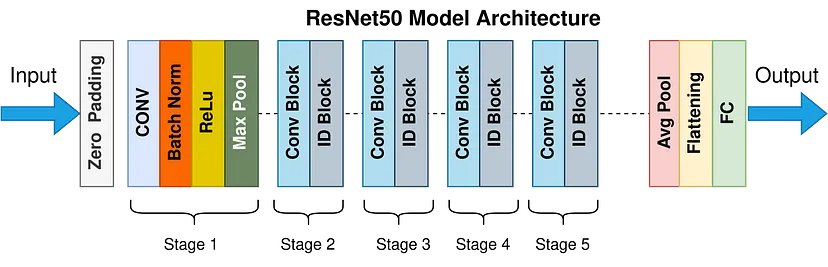                                                             
This above is the classical resnet architecture (https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758)

This is our modified resnet model                                                                                                
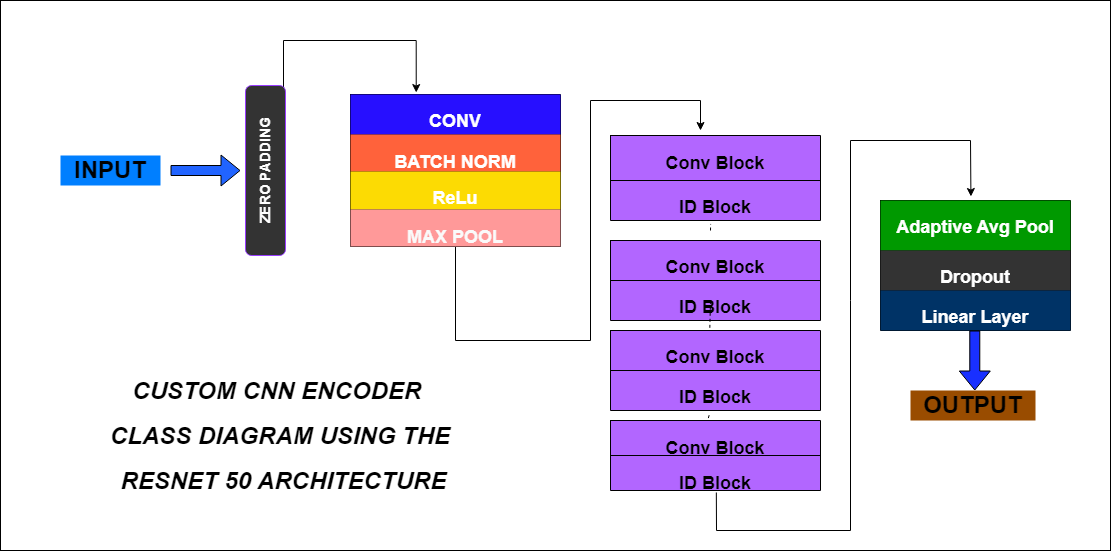

In [11]:
class CNN_encoder(nn.Module):
    def __init__(self, embed_size, dropout = 0.2):
        super(CNN_encoder, self).__init__()
        resnet = resnet50(weights = ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False)
                
        modules = list(resnet.children())[:-2]  # Remove the last classification layer
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)
        features = self.dropout(features)
        features = self.fc(features)
        return features

In our RNN_decoder class, we've designed an LSTM-based neural network for decoding tasks, like generating captions from images. We initialize it with the sizes for embeddings, hidden layers, and the vocabulary, along with the number of LSTM layers and a dropout rate to combat overfitting. In the forward pass, we start by embedding the captions, then concatenate these embeddings with the features from the encoder. This combined input is fed into the LSTM, followed by a dropout layer for regularization, and finally, a linear layer to predict the next word in the sequence. This setup helps us effectively generate sequences from complex features.

In [12]:
class RNN_decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout = 0.2):
        super(RNN_decoder, self).__init__()
        effective_dropout = dropout if num_layers > 1 else 0.0
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout = effective_dropout, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# 3. Setting the criteria for loss, initializing encoder and decoder objects then beginning the training process.
We have configured our models to run on a GPU if available, initializing our encoder and decoder, both with a 20% dropout rate, to process images and generate captions. We optimize their parameters using Adam with a learning rate of 0.001 and train for 14 epochs. Our loss function, designed to ignore padding, guides the training by comparing predicted captions against actual ones, allowing us to backpropagate errors and update our models accordingly. We track both training and validation losses to monitor progress and adjust for overfitting, ensuring our models improve at generating captions with each epoch.                                                                  

In [13]:
criterion = nn.CrossEntropyLoss(ignore_index = train_loader.dataset.vocab.word2idx['<PAD>'])
encoder_obj = CNN_encoder(embed_size = 256)
decoder_obj = RNN_decoder(embed_size = 256, hidden_size = 512, vocab_size = len(train_loader.dataset.vocab), num_layers = 1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


### Let's see the encoder class model summary

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder_obj.to(device)
decoder_obj.to(device)

print('The summary of the encoder class model is:')
torchsummary.summary(encoder_obj, input_size=(3, 224, 224))

The summary of the encoder class model is:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,

In [15]:
optimizer = optim.Adam(list(encoder_obj.parameters()) + list(decoder_obj.parameters()), lr = 0.001)

num_epochs = 14

for epoch in range(num_epochs):
    encoder_obj.train()
    decoder_obj.train()
    
    total_training_loss = 0
    
    for images, captions in train_loader:
        images, captions = images.to(device), captions.to(device)
        optimizer.zero_grad()
        features = encoder_obj(images)
        outputs = decoder_obj(features, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))
        loss.backward()
        optimizer.step()
        total_training_loss += loss.item()
    
    avg_training_loss = total_training_loss / len(train_loader)
    
    # Validation Phase
    encoder_obj.eval()
    decoder_obj.eval()
    
    total_val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            features = encoder_obj(images)
            outputs = decoder_obj(features, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch [1/14], Training Loss: 4.2156, Validation Loss: 3.5733
Epoch [2/14], Training Loss: 3.4257, Validation Loss: 3.2757
Epoch [3/14], Training Loss: 3.1760, Validation Loss: 3.1221
Epoch [4/14], Training Loss: 3.0108, Validation Loss: 3.0150
Epoch [5/14], Training Loss: 2.8744, Validation Loss: 2.9332
Epoch [6/14], Training Loss: 2.7631, Validation Loss: 2.8773
Epoch [7/14], Training Loss: 2.6655, Validation Loss: 2.8358
Epoch [8/14], Training Loss: 2.5769, Validation Loss: 2.8013
Epoch [9/14], Training Loss: 2.4951, Validation Loss: 2.7735
Epoch [10/14], Training Loss: 2.4163, Validation Loss: 2.7581
Epoch [11/14], Training Loss: 2.3420, Validation Loss: 2.7450
Epoch [12/14], Training Loss: 2.2698, Validation Loss: 2.7449
Epoch [13/14], Training Loss: 2.2012, Validation Loss: 2.7451
Epoch [14/14], Training Loss: 2.1289, Validation Loss: 2.7496


In [16]:
# Saving the state dictionaries of the encoder and decoder i.e the trained model
torch.save(encoder_obj.state_dict(), 'encoder_state_dict.pth')
torch.save(decoder_obj.state_dict(), 'decoder_state_dict.pth')

# 4. Model Evaluation on the Test set
For this first we fetch the actual test set captions in a list named "actual_test_captions", then we wrote a function that generates predicted captions and stores them in "predicted_test_captions". Then the metrics evaluation is performed.

In [17]:
def load_reference_captions(csv_file_path):
    df = pd.read_csv(csv_file_path)
    captions = df['caption'].tolist()
    return captions

# Path to the test.csv
csv_file_path = '/kaggle/input/dataset-zipped/custom_captions_dataset/test.csv'
actual_test_captions = load_reference_captions(csv_file_path)


#### Visualizing some captions...

In [54]:
print("Let's see the actual first five captions related to test set\n")
for i in range(5):
    print(f'Actual caption {i+1} : {actual_test_captions[i]}\n')

Let's see the actual first five captions related to test set

Actual caption 1 : A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it. 

Actual caption 2 : A person is skiing through the snow. There is loose snow all around them from him jumping. The person is wearing a yellow snow suit. The person is holding two ski poles in their hands. 

Actual caption 3 : There is a bed in a room against a wall. There is a brown blanket on top of the bed. There is a small brown book shelf next to the bed. There is a picture hanging on the wall above the shelf. 

Actual caption 4 : A black and red train is on the tracks and has steam coming out off of it. There is another train next to the first train that is orange. There is an overpass over the train tracks with cars on it. 

Actual caption 5 : A white and yellow public transportation bus with "122" on front is stopped with it's d

### Now generating the captions using the model for the test set.
===========================================================================================================================
### Parameters:
* **test_loader: DataLoader for the test set.**
* **encoder: Trained encoder model.**
* **decoder: Trained decoder model.**
* **vocab: Vocabulary instance.**

### Returns:
*  **captions: List of generated captions.**

In [18]:
def generate_captions_for_test_set(test_loader, encoder, decoder, vocab):
    encoder.eval()
    decoder.eval()
    counter = 0
    captions = []
    max_length = 50
    for images, _ in test_loader:
        images = images.to(device)
        features = encoder(images) # Generating features from the images
        
        for i in range(features.size(0)):  # Iterating through each image in the batch
            feature = features[i].unsqueeze(0)
            output_ids = [vocab.word2idx['<START>']]
            #max_length = len(actual_test_captions[counter])
            #counter += 1
            for _ in range(max_length):
                current_sequence = torch.tensor([output_ids], device = device)
                with torch.no_grad():
                    outputs = decoder(feature, current_sequence)
                predicted = outputs[:, -1, :].argmax(1)
                predicted_id = predicted.item()
                if predicted_id == vocab.word2idx['<UNK>']:   # If any unknown i.e, '<UNK>' token then skipping it
                    continue
                if predicted_id == vocab.word2idx['<END>']:   # As soon as we reach the '<END>' token we break, till the  appending the word indeices to the list
                    break
                output_ids.append(predicted_id)
            
            # Converting the output sequence of IDs back to words & skipping <START> and <END> tokens.
            generated_caption = [vocab.idx2word[idx] for idx in output_ids[1:-1]]
            captions.append(' '.join(generated_caption))
    
    return captions

# Generating captions for the test set
predicted_test_captions = generate_captions_for_test_set(test_loader, encoder_obj, decoder_obj, train_loader.dataset.vocab)

In [19]:
# Printing the first 5 predicted captions from the test set
for i, caption in enumerate(predicted_test_captions[:5]):
    print(f'Generated Caption for test image {i+1}: "{caption}"\n')

Generated Caption for test image 1: "a large white building sits behind a building . there is a large black and white building behind the bus . there is a red bus on the street . there is a red bus on the street . there is a red bus on the side of the"

Generated Caption for test image 2: "a person is wearing a black jacket and black pants . the person is wearing a black jacket and black pants . the person is wearing a black jacket and black pants . the person is wearing a black jacket and black pants . the person is wearing a"

Generated Caption for test image 3: "a large bed is sitting in a room . there is a white rug on the bed . there is a white rug on the table . there is a white rug on the table . there is a white rug on the table . there is a white"

Generated Caption for test image 4: "a train is on the tracks . the train is blue and yellow . the train is on the train tracks . the train is on the tracks . the train is on the tracks . the train is blue with yellow stripes . the 

In [20]:
# For certain images the model is unable to generate captions 
# Thus for those filling the predicted caption by  a default value lets say 'no caption'

for i in range(len(predicted_test_captions)):
    if predicted_test_captions[i] == '':
        predicted_test_captions[i] = 'no caption'

### Printing the metric values, the metrics CIDEr and SPICE use a special format
### That is a dictionary that has the key/index as image name and key-value as a list of caption(s) for that image

In [58]:
def tweak_data():
    captions_predicted = {}
    captions_actual = {}
    for index, (predicted, actual) in enumerate(zip(predicted_test_captions, actual_test_captions)):
        image_id = str(index)
        captions_predicted[image_id] = [predicted]
        captions_actual[image_id] = [actual]
    
    return captions_predicted, captions_actual


def evaluate_metrics():
    
    # First let's do ROUGE-L
    rouge = Rouge()
    scores = rouge.get_scores(predicted_test_captions, actual_test_captions, avg = True)
    rouge_l_score = scores['rouge-l']['f']
    
    # For CIDEr and SPICE we need a teeny tiny tweaking in sending the actual captions and predicted captions
    # Doing that first...
    print('\nLoading some resources...')
    predicted_captions , actual_captions = tweak_data()
    cider_scorer = Cider()
    spice_scorer = Spice()
    
    cider_score, _ = cider_scorer.compute_score(actual_captions, predicted_captions)
    spice_score, _ = spice_scorer.compute_score(actual_captions, predicted_captions)
    
    return rouge_l_score, cider_score, spice_score
    

**NOTE : SPICE will take a few minutes the first time, but speeds up due to caching**

In [59]:
warnings.filterwarnings("ignore")

rouge_score, cider_score, spice_score = evaluate_metrics()
print('\n\nThe metrics after evaluation are...')
print(f'\nThe ROUGE-L score is : {rouge_score}\n')
print(f'The CIDEr score is: {cider_score}\n')
print(f'The SPICE score is: {spice_score}')   


Loading some resources...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 3.484 min


The metrics after evaluation are...

The ROUGE-L score is : 0.269982538788438

The CIDEr score is: 0.028215051499469436

The SPICE score is: 0.09003152037129201


## Now taking an image input from user and giving away its generated caption for output

In [36]:
# For transforming one image that is selected
transform_one = Compose([Resize((224, 224)), ToTensor(), Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# If you change the last value test with train or val then it will choose from those sets
dataset_path = '/kaggle/input/dataset-zipped/custom_captions_dataset/test'
image_files = os.listdir(dataset_path)
image_files.sort()

def generate(encoder, decoder, vocab, image):
    image = transform_one(image).unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        features = encoder(image)
        output_ids = [vocab.word2idx['<START>']]
        for _ in range(30):
            current_sequence = torch.tensor([output_ids], device = device)
            outputs = decoder(features, current_sequence)
            predicted = outputs[:, -1, :].argmax(1)
            predicted_id = predicted.item()
            if predicted_id == vocab.word2idx['<UNK>']:   # If any unknown i.e, '<UNK>' token then skipping it
                continue
            if predicted_id == vocab.word2idx['<END>']:   # As soon as we reach the '<END>' token we break, till the  appending the word indeices to the list
                break
            output_ids.append(predicted_id)
        caption = ' '.join(vocab.idx2word[idx] for idx in output_ids[1:] if idx not in [vocab.word2idx['<START>'], vocab.word2idx['<END>']])
    return caption

# Dropdown menu for image selection
dropdown = Dropdown(options = image_files, description = 'Select Image:', disabled = False)
output = Output()


def handle_image_file(change):
    image_path = os.path.join(dataset_path, change['new'])
    image = Image.open(image_path).convert("RGB")
    
    caption = generate(encoder_obj, decoder_obj, vocab, image)
    
    with output:
        output.clear_output()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print("Output : ", caption)

dropdown.observe(handle_image_file, names = 'value')
display(VBox([dropdown, output]))

### As mentioned the  last cell has the generated captions from the test set

In [60]:
for i in range(len(predicted_test_captions)):
    print(f'Test_img_{i+1}: {predicted_test_captions[i]}\n')

Test_img_1: there is a large building with a clock on it . there is a clock on the side of the building . there is a clock on the side of the building . there is a clock on the side of the building

Test_img_2: a man is standing on a surfboard . he is wearing a black wet suit . he is wearing a black wet suit . he is also wearing a black wet suit . the man is wearing a black wet suit . he is also wearing a black wet

Test_img_3: a white couch with a white desk is sitting in front of a computer desk . there is a white desk in front of the couch . there is a white keyboard on the desk

Test_img_4: a train is on the tracks . the train is white and blue . the train is yellow and black . the train is yellow and black . there are many windows on the train . there is a train on the platform

Test_img_5: there is a white bus on the street . there is a white van on the street . there is a white building behind the bus . there is a white building behind the bus . there is a white building behind 